In [ ]:
import ee
import geemap
import geemap.datasets as gds
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widget
from ipywidgets import Output
from datetime import datetime

import spectral_indices as spec_ind
import vis_params as vis

In [46]:
ee.Authenticate()

True

In [47]:
ee.Initialize()
geemap.ee_initialize()

Define the Palisades Fire AOI for processing

In [48]:
# Define the area of interest (Los Angeles)
aoi = ee.Geometry.Rectangle([-119, 33.5, -117, 35])  # LA region

palisades_fire = ee.Geometry.Polygon([
  [
    [-118.735, 34.142],  #// Top left
    [-118.496, 34.142],   #// Top right
    [-118.496, 34.037],   #// Bottom right
    [-118.735, 34.037]   #// Bottom left
  ]
]);

palisades_subregion1 = ee.Geometry.Polygon([
  [
    [-118.65, 34.065],  # Top left
    [-118.58, 34.065],   # Top right
    [-118.58, 34.045],  # Bottom right
    [-118.65, 34.045]   # Bottom left
  ]
]);

palisades_subregion2 = ee.Geometry.Polygon([
  [
    [-118.548, 34.120], # Top left
    [-118.515, 34.120], # Top right
    [-118.515, 34.090], # Bottom right
    [-118.548, 34.090]  # Bottom left
  ]
]);

# Convert the Geometry to FeatureCollection
pf_fc = ee.FeatureCollection([ee.Feature(palisades_fire)])
pf_subregion1_fc = ee.FeatureCollection([ee.Feature(palisades_subregion1)])
pf_subregion2_fc = ee.FeatureCollection([ee.Feature(palisades_subregion2)])

Use Sentinel-2 imagery to generate a pre-fire/post-fire image

In [49]:
# Pre-fire image - Took the mean over period preceeding
pre_fire = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .filterBounds(aoi)
    .filterDate("2024-11-01", "2025-01-03")  # BEFORE the fire
    .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 10))
    .mean()
    .clip(palisades_fire)
)

# Post-fire image - Took the mean over period after
post_fire = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .filterBounds(aoi)
    .filterDate("2025-01-07", "2025-02-07")  # AFTER the fire
    .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 10))
    .mean()
    .clip(palisades_fire)
)

Generate Map of RGB/False Colour Imagery

In [50]:
# Create Map
Map = geemap.Map()

# Update center to Los Angeles
Map.setCenter(-118.616274, 34.080690, 12)  

# Add layers
Map.addLayer(pre_fire, vis.vis_false_colour, 'Pre-Fire, FC')
Map.addLayer(post_fire, vis.vis_false_colour, 'Post-Fire, FC')
Map.addLayer(pre_fire, vis.vis_rgb, 'Pre-Fire, RGB')
Map.addLayer(post_fire, vis.vis_rgb, 'Post-Fire RGB')

# Add the polygon to the map with a red border and transparent fill
Map.addLayer(pf_fc.style(**vis.vis_large_polygon), {}, 'Palisades Fire')

# Show Map
Map

Map(center=[34.08069, -118.616274], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Sea…

Perform Band Processing to generate NDVI/NDMI/dNBR

In [51]:
# Create an instance of the SpectralIndices class  
spectral_indices = spec_ind.SpectralIndices() 

#Calculate NDVI for pre-fire and post-fire images
NDVI_pre_fire = spectral_indices.calculate_ndvi(pre_fire)
NDVI_post_fire = spectral_indices.calculate_ndvi(post_fire)
dNDVI = spectral_indices.calculate_dndvi(NDVI_pre_fire, NDVI_post_fire)

In [52]:
#Calculate NBR for pre-fire and post-fire images
NBR_pre_fire = spectral_indices.calculate_nbr(pre_fire)
NBR_post_fire = spectral_indices.calculate_nbr(post_fire)
dNBR = spectral_indices.calculate_dnbr(NBR_pre_fire, NBR_post_fire)

Plot the NDVI and dNBR Maps

In [53]:
# Create Map
Map = geemap.Map()

# Update center to Los Angeles
Map.setCenter(-118.616274, 34.080690, 12)  

# Add the polygon to the map with a red border and transparent fill
Map.addLayer(pf_fc.style(**vis.vis_large_polygon), {}, 'Palisades Fire Boundary')

# Add layers
Map.addLayer(NDVI_pre_fire, vis.NDVI_vis_params, 'Pre-Fire, NDVI')
Map.addLayer(NDVI_post_fire, vis.NDVI_vis_params, 'Post-Fire, NDVI')

# Create the map and add the legend
Map.add_legend(title="NDVI Classes", keys=vis.NDVI_legend_keys, colors=vis.NDVI_legend_colors)

# Show Map
Map

Map(center=[34.08069, -118.616274], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Sea…

In [ ]:
# Create Map
Map = geemap.Map()

# Update center to Los Angeles
Map.setCenter(-118.616274, 34.080690, 12)  

# Add the polygon to the map with a red border and transparent fill
Map.addLayer(pf_fc.style(**vis.vis_large_polygon), {}, 'Palisades Fire Boundary')

#Add Layers
Map.addLayer(dNBR, vis.dNBR_vis_params, "dNBR (Burn Severity)")
Map.add_legend(title="dNBR Burn Severity", keys=vis.dNBR_legend_keys, colors=vis.dNBR_legend_colors)

Map.addLayer(pf_subregion1_fc.style(**vis.vis_small_polygon), {}, 'Subregion(1)')
Map.addLayer(pf_subregion2_fc.style(**vis.vis_small_polygon), {}, 'Subregion(2)')

Map

Map(center=[34.08069, -118.616274], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Sea…

Generate an extended image collection so that we can extract timeseries information to see recovery rates

In [55]:
# Define date range for analysis
start_date = '2024-09-01'
end_date = '2025-04-20'

# Load Sentinel-2 image collection so that we can generate a timeseries of images
collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
              .filterBounds(palisades_fire)
              .filterDate(start_date, end_date)
              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)))

Calulate the NDVI/NDMI for each subregion

In [56]:
# Calculate both NDVI and NDMI for each image in subregion1
index_features_subregion1 = collection.map(lambda image: spectral_indices.process_index(image, palisades_subregion1))
index_results_subregion1 = index_features_subregion1.getInfo()

# Initialize lists for subregion1 results
dates_subregion1 = []
ndvi_values_subregion1 = []
ndmi_values_subregion1 = []

# Collect results for subregion1 (NDVI and NDMI)
for feature in index_results_subregion1['features']:
    props = feature['properties']
    date = props['date']
    ndvi = props.get('mean_ndvi')
    ndmi = props.get('mean_ndmi')

    if ndvi is not None and ndmi is not None:
        dates_subregion1.append(datetime.strptime(date, '%Y-%m-%d'))
        ndvi_values_subregion1.append(ndvi)
        ndmi_values_subregion1.append(ndmi)

In [57]:
# Calculate both NDVI and NDMI for each image in subregion2
index_features_subregion2 = collection.map(lambda image: spectral_indices.process_index(image, palisades_subregion2))
index_results_subregion2 = index_features_subregion2.getInfo()

# Initialize lists for subregion2 results
dates_subregion2 = []
ndvi_values_subregion2 = []
ndmi_values_subregion2 = []

# Collect results for subregion2 (NDVI and NDMI)
for feature in index_results_subregion2['features']:
    props = feature['properties']
    date = props['date']
    ndvi = props.get('mean_ndvi')
    ndmi = props.get('mean_ndmi')

    if ndvi is not None and ndmi is not None:
        dates_subregion2.append(datetime.strptime(date, '%Y-%m-%d'))
        ndvi_values_subregion2.append(ndvi)
        ndmi_values_subregion2.append(ndmi)

Plot the mean NDVI/NDMI timeseries for each timeseries

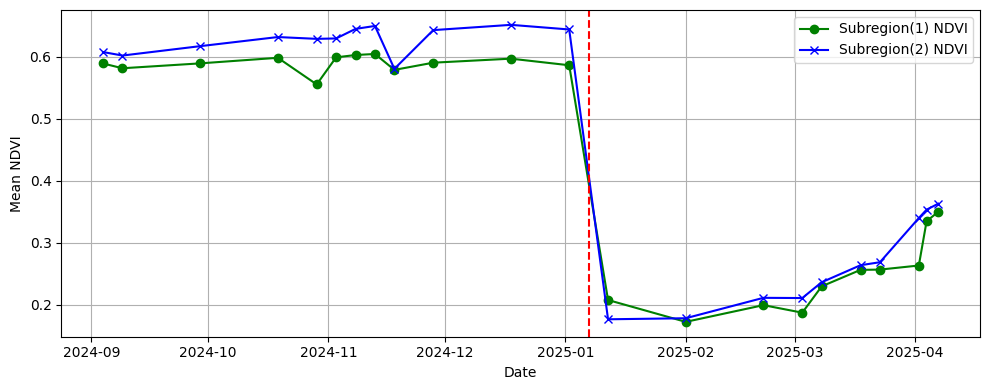

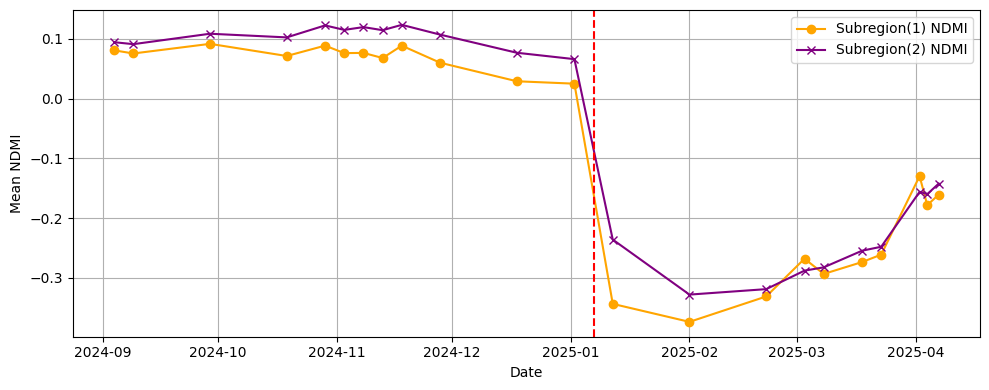

In [58]:
# Fire start date
fire_start = datetime(2025, 1, 7)

# Plot NDVI for both subregions in one plot
plt.figure(figsize=(10, 4))
plt.plot(dates_subregion1, ndvi_values_subregion1, label='Subregion(1) NDVI', marker='o', linestyle='-', color='green')
plt.plot(dates_subregion2, ndvi_values_subregion2, label='Subregion(2) NDVI', marker='x', linestyle='-', color='blue')
plt.axvline(fire_start, color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Mean NDVI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot NDMI for both subregions in one plot
plt.figure(figsize=(10, 4))
plt.plot(dates_subregion1, ndmi_values_subregion1, label='Subregion(1) NDMI', marker='o', linestyle='-', color='orange')
plt.plot(dates_subregion2, ndmi_values_subregion2, label='Subregion(2) NDMI', marker='x', linestyle='-', color='purple')
plt.axvline(fire_start, color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Mean NDMI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Generate a histogram of the dNBR values

In [59]:
dnbr_histogram = dNBR.reduceRegion(
    reducer=ee.Reducer.histogram(),
    scale=10,
    maxPixels=1e13,
    bestEffort=True  # Allow Earth Engine to handle large regions
)

# Retrieve the histogram data
histogram_info = dnbr_histogram.getInfo()

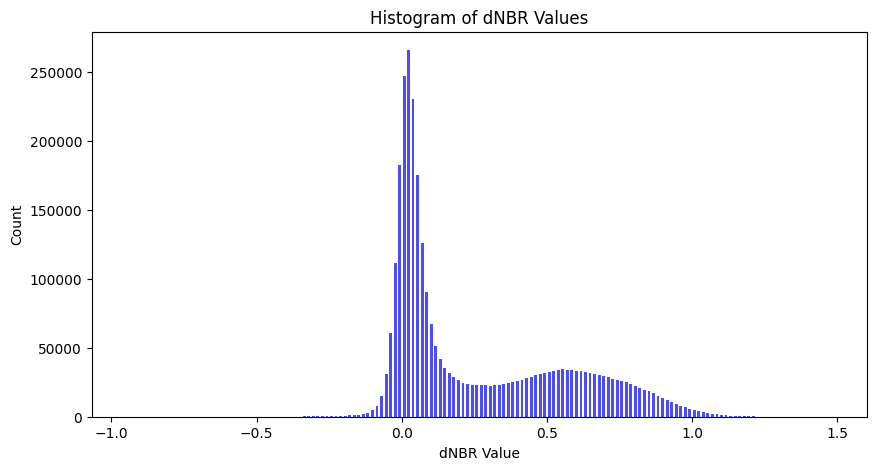

In [66]:
# Extract the histogram data
bucket_means = histogram_info['dNBR']['bucketMeans']
counts = histogram_info['dNBR']['histogram']

# Plot the histogram
plt.figure(figsize=(10, 5))
plt.bar(bucket_means, counts, width=0.01, color='blue', alpha=0.7) 
plt.xlabel('dNBR Value')
plt.ylabel('Count')
plt.title('Histogram of dNBR Values')
plt.show()


Apply simple thresholding to the dNBR values to generate a burned/unburned region

In [61]:
# Set the threshold for classification
threshold = 0.26  # Adjust if needed

# Create a mask for burned areas (dNBR >= 0.26)
burned_mask = dNBR.gt(threshold)

# Mask the dNBR image to isolate burned areas
burned_region = dNBR.updateMask(burned_mask)

# Create a mask for non-burned areas (dNBR <= 0.26)
non_burned_mask = dNBR.lte(threshold)

# Mask the dNBR image to isolate non-burned areas
non_burned_region = dNBR.updateMask(non_burned_mask)

Plot the thresholded distribution to check we are masking correct pixels

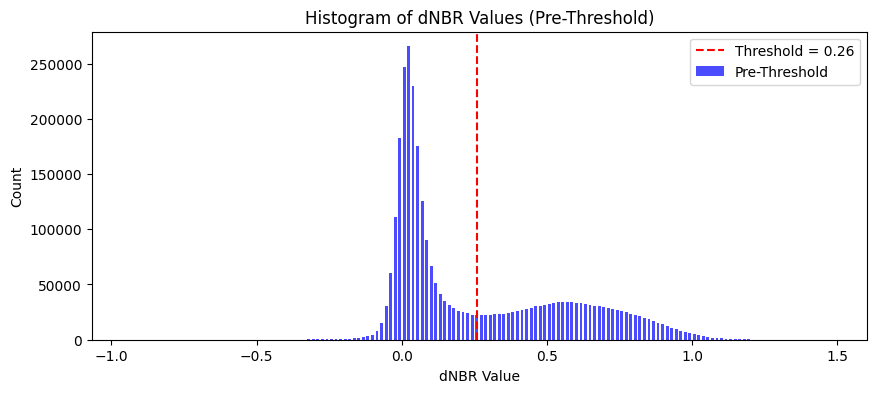

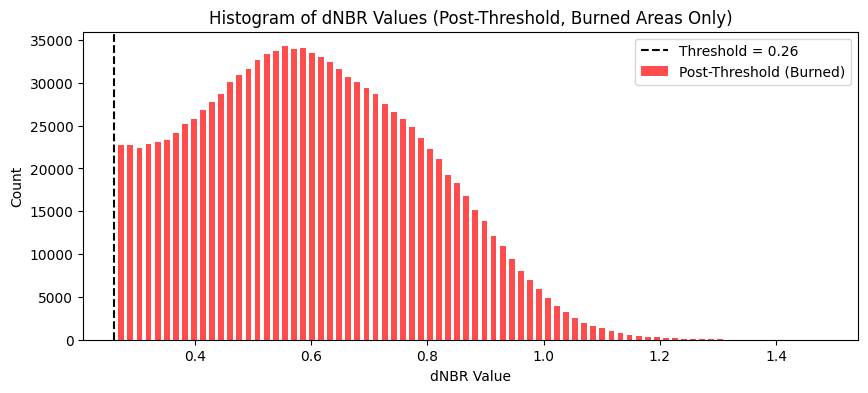

In [62]:
# Visualize the dNBR values (pre-threshold) to see the distribution
bucket_means = histogram_info['dNBR']['bucketMeans']
counts = histogram_info['dNBR']['histogram']

# Plot the pre-threshold histogram
plt.figure(figsize=(10, 4))
plt.bar(bucket_means, counts, width=0.01, color='blue', alpha=0.7, label='Pre-Threshold')
plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
plt.xlabel('dNBR Value')
plt.ylabel('Count')
plt.title('Histogram of dNBR Values (Pre-Threshold)')
plt.legend()
plt.show()

burned_counts = []
burned_means = []

for mean, count in zip(bucket_means, counts):
    if mean > threshold:
        burned_means.append(mean)
        burned_counts.append(count)

# Plot the histogram of the burned area only (post-threshold)
plt.figure(figsize=(10, 4))
plt.bar(burned_means, burned_counts, width=0.01, color='red', alpha=0.7, label='Post-Threshold (Burned)')
plt.axvline(x=threshold, color='black', linestyle='--', label=f'Threshold = {threshold}')
plt.xlabel('dNBR Value')
plt.ylabel('Count')
plt.title(f'Histogram of dNBR Values (Post-Threshold, Burned Areas Only)')
plt.legend()
plt.show()

Add the burned/unburned masked layers to the map

In [63]:
# Create Map
Map = geemap.Map()

# Update center to Los Angeles
Map.setCenter(-118.616274, 34.080690, 12)  

# Add the polygon to the map with a red border and transparent fill
Map.addLayer(pf_fc.style(**vis.vis_large_polygon), {}, 'Palisades Fire')

Map.addLayer(dNBR, vis.dNBR_vis_params, 'dNBR (Burn Severity)')
# Visualize the burned area
Map.addLayer(burned_region, vis.burned_region_params, 'Burned Area')
# Visualize the non-burned area
Map.addLayer(non_burned_region, vis.non_burned_region_params, 'Non-Burned Area')

# Show the map
Map

Map(center=[34.08069, -118.616274], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Sea…

Finally, calculate an estimate of the area of the burnt region

In [64]:
# Calculate the area of burned regions
burned_area = burned_region.multiply(ee.Image.pixelArea())  # Multiply by pixel area to get area in square meters
burned_area_stats = burned_area.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=palisades_fire,  # Use the fire boundary as the region
    scale=10,  # Scale in meters
    maxPixels=1e13
)

# Retrieve the results
burned_area_m2 = burned_area_stats.getInfo().get('dNBR')

# Convert to square kilometers (1 km² = 1,000,000 m²)
burned_area_km2 = burned_area_m2 / 1e6

# Print the results
print(f"Burned Area: {burned_area_km2:.2f} km²")

Burned Area: 58.51 km²
